In [1]:
import time
import re
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout,       # General
    Embedding, LSTM, Dense, GRU,                              # RNN
    Conv2D, Conv2DTranspose, LeakyReLU, MaxPool2D, Flatten    # CNN
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid

print(tf.__version__)

2.2.0


## **Preprocessing**

In [7]:
# Read the Divina Commedia
url = "https://raw.githubusercontent.com/DanieleVeri/deep_comedy/feature/GANs/divina_commedia.txt"
response = requests.get(url)

divina_commedia = response.text

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")
divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")
divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }

def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list

encoded_text = numerical_encoding(divina_commedia, char2idx)

def get_text_matrix(sequence, len_input):
    X = np.empty((len(sequence)-len_input, len_input))
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
    return X

text_matrix = get_text_matrix(encoded_text, 100)

print(text_matrix.shape)

(533803, 100)


## **LSTM training**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 250)          15500     
_________________________________________________________________
lstm (LSTM)                  (100, None, 1000)         5004000   
_________________________________________________________________
dense (Dense)                (100, None, 250)          250250    
_________________________________________________________________
dense_1 (Dense)              (100, None, 62)           15562     
Total params: 5,285,312
Trainable params: 5,285,312
Non-trainable params: 0
_________________________________________________________________
0
1.  	  Loss: 2.42193603515625  	  Time: 34.63ss
1
2.  	  Loss: 2.0619657039642334  	  Time: 27.24ss
2
3.  	  Loss: 1.9014360904693604  	  Time: 27.18ss
3
4.  	  Loss: 1.7729706764221191  	  Time: 27.16ss
4
5.  	  Loss: 1.674802303314209  	  T

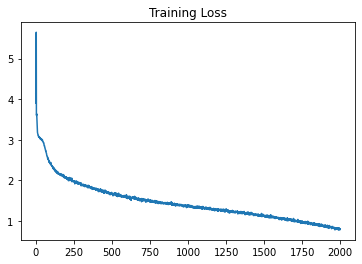

In [3]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 100
# size of training subset at each epoch
subset_size = batch_size * 100
# vector size of char embeddings
embedding_size = 250
len_input = 1000   # 200
hidden_size = 250  # for Dense() layers

n_epochs = 20
learning_rate = 1e-3

char_input = Input(shape=(batch_shape,))
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(len_input, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])
RNN.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, RNN(x), from_logits = True))
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    print(epoch)
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))
    
    
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

RNN.save("/text_generator_RNN_00.h5")

## **LSTM generation:**

In [4]:
generator = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    
    LSTM(len_input, return_sequences = True, stateful=True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

generator.summary()

# Import trained weights from RNN to generator
generator.set_weights(RNN.get_weights())

def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))

init="""
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
"""
print(generate_text(init))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 250)            15500     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1000)           5004000   
_________________________________________________________________
dense_2 (Dense)              (1, None, 250)            250250    
_________________________________________________________________
dense_3 (Dense)              (1, None, 62)             15562     
Total params: 5,285,312
Trainable params: 5,285,312
Non-trainable params: 0
_________________________________________________________________

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
  La nostra d'una padre e sovra 'l sole Alette;
per ch'io il dovo tutto di gran divizia,
sì che la speranza fherda s'iccende;
  che tu mi 